Task 1: Data Understanding and Visualization


In [1]:
!pip install Pillow

In [2]:
!pip install matplotlib

In [3]:
!gdown 1pDBeGzlhBiPhhUYj8nSKgm2A-G0ZsQ0A

Downloading...
From: https://drive.google.com/uc?id=1pDBeGzlhBiPhhUYj8nSKgm2A-G0ZsQ0A
To: /content/Copy of FruitinAmazon.zip
100% 1.24M/1.24M [00:00<00:00, 115MB/s]


In [4]:
!unzip Copy\ of\ FruitinAmazon.zip

Archive:  Copy of FruitinAmazon.zip
  inflating: FruitinAmazon/test/cupuacu/download (5).jpeg  
  inflating: FruitinAmazon/test/acai/images (2).jpeg  
  inflating: FruitinAmazon/test/cupuacu/download (3).jpeg  
  inflating: FruitinAmazon/test/acai/images (16).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (2).jpeg  
  inflating: FruitinAmazon/train/pupunha/images (1).jpeg  
  inflating: FruitinAmazon/test/cupuacu/download (2).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (1).jpeg  
  inflating: FruitinAmazon/train/acai/images (3).jpeg  
  inflating: FruitinAmazon/train/acai/images (4).jpeg  
  inflating: FruitinAmazon/test/graviola/download (1).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (11).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (4).jpeg  
  inflating: FruitinAmazon/train/acai/images (11).jpeg  
  inflating: FruitinAmazon/test/tucuma/download (1).jpeg  
  inflating: FruitinAmazon/test/acai/images.jpeg  
  inflating: FruitinAmazon/train/

In [5]:
!pip install gdown

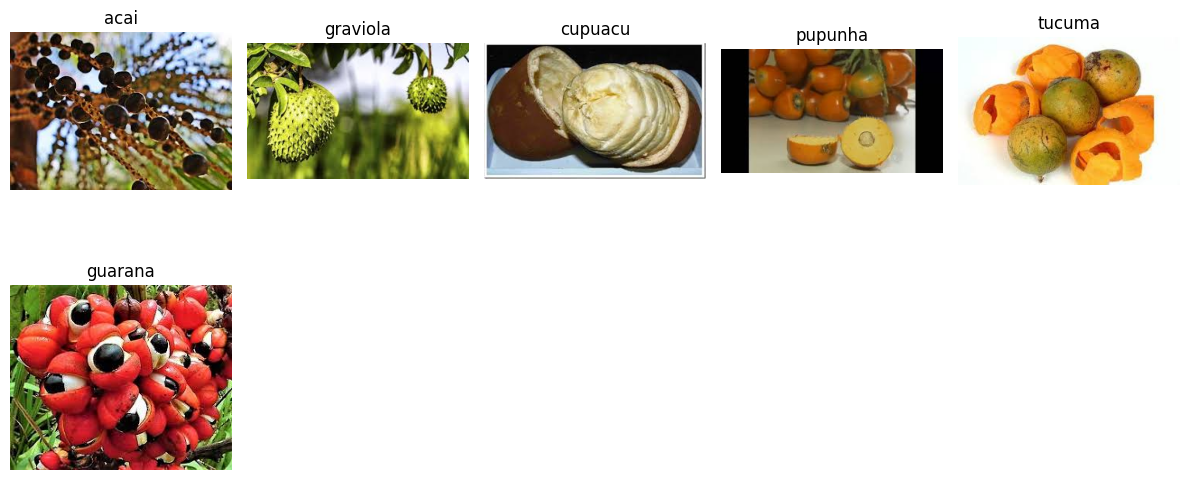

In [7]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

# Set your dataset path
train_dir = '/content/FruitinAmazon/train'

# Get class names
class_names = os.listdir(train_dir)

# Display random image from each class
plt.figure(figsize=(12, 6))
for i, fruit_class in enumerate(class_names[:10]):  # limit to 10 classes for visual clarity
    class_path = os.path.join(train_dir, fruit_class)
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)
    img = Image.open(img_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.title(fruit_class)
    plt.axis('off')
plt.tight_layout()
plt.show()

This code displays a random sample image from each fruit class in the Amazon Fruit dataset. It helps us visually understand the dataset structure and image quality.

In [8]:
from PIL import UnidentifiedImageError

corrupted = []

for fruit_class in os.listdir(train_dir):
    class_path = os.path.join(train_dir, fruit_class)
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        try:
            img = Image.open(img_path)
            img.verify()  # verifies integrity
        except (UnidentifiedImageError, IOError, SyntaxError):
            print(f"Removed corrupted image: {img_path}")
            corrupted.append(img_path)
            os.remove(img_path)

if not corrupted:
    print("No corrupted images found.")

No corrupted images found.


Task 2: Loading and Preprocessing Image Data


In [9]:
import tensorflow as tf

img_height, img_width = 128, 128
batch_size = 32
validation_split = 0.2
rescale = tf.keras.layers.Rescaling(1./255)

# Load training set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=validation_split,
    subset='training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

#  Extract class names BEFORE mapping
class_names = raw_train_ds.class_names
num_classes = len(class_names)
print(f"Number of classes: {num_classes}")
print("Class names:", class_names)

# Then apply rescaling
train_ds = raw_train_ds.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 72 files for training.
Number of classes: 6
Class names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


Task 3: Build CNN Model

In [10]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128, 128, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

Task 4: Compile the Model

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Task 5: Train the Model

In [13]:
# Define validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(128, 128),
    batch_size=32
)

# Apply only rescaling (no augmentation)
rescale = tf.keras.layers.Rescaling(1./255)
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpoint_cb = ModelCheckpoint("best_model.h5", save_best_only=True)
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    callbacks=[checkpoint_cb, earlystop_cb]
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.1453 - loss: 1.8460

3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 924ms/step - accuracy: 0.1437 - loss: 1.8525 - val_accuracy: 0.2778 - val_loss: 1.8020
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.3918 - loss: 1.5758

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 546ms/step - accuracy: 0.3806 - loss: 1.5829 - val_accuracy: 0.2778 - val_loss: 1.7774
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.3837 - loss: 1.4668

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 547ms/step - accuracy: 0.3919 - loss: 1.4567 - val_accuracy: 0.3333 - val_loss: 1.7028
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.5382 - loss: 1.1660

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 0.5495 - loss: 1.1567 - val_accuracy: 0.2778 - val_loss: 1.6085
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step - accuracy: 0.6696 - loss: 0.8917

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 555ms/step - accuracy: 0.6723 - loss: 0.8933 - val_accuracy: 0.5000 - val_loss: 1.3069
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 812ms/step - accuracy: 0.8168 - loss: 0.7067 - val_accuracy: 0.4444 - val_loss: 1.6834
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - accuracy: 0.7853 - loss: 0.5889

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 541ms/step - accuracy: 0.7834 - loss: 0.5959 - val_accuracy: 0.5000 - val_loss: 1.2965
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 480ms/step - accuracy: 0.8976 - loss: 0.4472 - val_accuracy: 0.3889 - val_loss: 1.3122
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - accuracy: 0.9349 - loss: 0.2746 - val_accuracy: 0.5556 - val_loss: 1.6304
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 446ms/step - accuracy: 0.9783 - loss: 0.2152 - val_accuracy: 0.5556 - val_loss: 1.4179
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 442ms/step - accuracy: 0.9410 - loss: 0.1903 - val_accuracy: 0.5000 - val_loss: 1.9382
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 618ms/step - accuracy: 0.9627 - loss: 0.1430 - val_accuracy: 0.5000 - val_loss: 2.1211
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 763ms/step - accuracy: 0.9783 - loss: 0.1060 - val_accuracy: 0.3333 - val_loss: 1.9233
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 472ms/step - accuracy: 0.9783 - loss: 0.0749 - val_accuracy: 0.5000 - val_loss

Task 6: Evaluate the Model

In [15]:
test_loss, test_acc = model.evaluate(val_ds)
print(f"Test Accuracy: {test_acc:.4f}, Loss: {test_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.5000 - loss: 1.2965
Test Accuracy: 0.5000, Loss: 1.2965


Task 7: Save, Load, and Predict


In [16]:
model.save("fruit_model.h5")
loaded_model = tf.keras.models.load_model("fruit_model.h5")

In [17]:
import numpy as np
from sklearn.metrics import classification_report

# Predict
y_pred_probs = loaded_model.predict(val_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = np.concatenate([y for x, y in val_ds], axis=0)

# Classification report
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
              precision    recall  f1-score   support

        acai       0.50      1.00      0.67         1
     cupuacu       0.20      0.50      0.29         2
    graviola       0.00      0.00      0.00         3
     guarana       0.20      0.20      0.20         5
     pupunha       0.00      0.00      0.00         4
      tucuma       0.00      0.00      0.00         3

    accuracy                           0.17        18
   macro avg       0.15      0.28      0.19        18
weighted avg       0.11      0.17      0.12        18

